In [1]:
# Библиотеки
import pandas as pd
pd.set_option('display.max_rows', 550)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)
from nltk.stem import SnowballStemmer 
from pymystem3 import Mystem
import datetime
from io import BytesIO
import requests
import re
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from numpy import arange
import seaborn as sns
import plotly.express as px
import warnings as warning
warning.filterwarnings('ignore')
import statistics


In [2]:
path_1 = 'D://Kseniia//AV//' 
data = pd.read_csv(path_1 + 'AV_bq-results-20210713_red.csv')


In [3]:
# Основная информация о таблице
data.info()
display(data.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1862106 entries, 0 to 1862105
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   user_id         int64  
 1   transaction_id  int64  
 2   reciept_cost    float64
 3   deliveryZone    object 
 4   comments        float64
 5   cat_delv        object 
 6   date            object 
dtypes: float64(2), int64(2), object(3)
memory usage: 99.4+ MB


,user_id,transaction_id,reciept_cost,deliveryZone,comments,cat_delv,date
0,8903271874564,1779863839,5613.30,mo,NaN,storage_msk,2021-01-11
1,8848493969412,1792865067,5787.00,mo,NaN,storage_msk,2021-01-11
2,8906460135428,1786615161,8728.00,mo,NaN,storage_msk,2021-01-11
3,8912425451524,1794672582,4049.32,mo,NaN,storage_msk,2021-01-11
4,8904413380612,1780003217,4477.00,mo,NaN,storage_msk,2021-01-11
5,8947878887428,1794696215,8050.00,mo,NaN,storage_msk,2021-01-11
6,8907171921924,1781576459,4171.90,mo,NaN,storage_msk,2021-01-11
7,8900968775684,1791471630,6987.60,mo,NaN,storage_msk,2021-01-11
8,8899019898884,1793805778,5819.40,mo,NaN,storage_msk,2021-01-11
9,8801222590468,1791560735,8297.82,mo,NaN,storage_msk,2021-01-11


In [4]:
# Посмотрим на поведение клиентов за год
orders = data[['user_id', 'date', 'reciept_cost', 'cat_delv']]
orders['date'] = orders['date'].astype('datetime64[h]')
orders = orders.query('date > "2020-07-13"')
print(orders['date'].min())
print(orders['date'].max())

2020-07-14 00:00:00
2021-07-13 00:00:00


In [5]:
# Дата совершения первого события пользователя в сервисе
min_month_order = orders.groupby(['user_id', 'cat_delv'])['date'].min()
min_month_order.name = 'min_month_order'
min_month_order = min_month_order.reset_index()
orders = orders.merge(min_month_order,on=['user_id', 'cat_delv'], how = 'left') 
orders['min_month_order'] = orders['min_month_order'].astype('datetime64[M]')
#orders['order_month'] = orders['date'].astype('datetime64[M]')
orders.sort_values(by = 'user_id')

,user_id,date,reciept_cost,cat_delv,min_month_order
96363,8799688032260,2021-03-18,17988.60,storage_msk,2020-10-01
337059,8799688032260,2021-07-09,4911.80,omni_msk,2020-10-01
335627,8799688032260,2021-01-10,16943.41,omni_msk,2020-10-01
158765,8799688032260,2020-10-18,7531.36,omni_msk,2020-10-01
158764,8799688032260,2020-10-11,4705.40,omni_msk,2020-10-01
...,...,...,...,...,...
184585,8972989792260,2021-07-13,602.00,omni_msk,2021-07-01
32321,8972989792260,2021-07-13,187.00,omni_msk,2021-07-01
32785,8973008011268,2021-07-12,10180.50,omni_msk,2021-07-01
33642,8973009223684,2021-07-12,1578.10,omni_msk,2021-07-01


In [6]:
# Сгруппируем датафрейм по пользователям и подсчитаем количество уникальных сервисов:
count_cat_delv_by_users = orders.groupby(['user_id']).agg({'cat_delv':'nunique'}).reset_index()
count_cat_delv_by_users = count_cat_delv_by_users.rename(columns={'cat_delv':'number_cat_delv'})
count_cat_delv_by_users['number_cat_delv'].value_counts()


1    68854
2    15758
3      661
4       84
5        4
Name: number_cat_delv, dtype: int64

In [7]:
# Разделим пользователей по целевому поведению

#  Список пользователей с 1 видом сервиса
count_cat_delv_by_users['is_target_behavior'] = (count_cat_delv_by_users['number_cat_delv'] < 2)
user_ids_with_target_behavior_1 = count_cat_delv_by_users[count_cat_delv_by_users['is_target_behavior']]['user_id'].unique()

#  Список пользователей с 2 и более видами видом сервиса
count_cat_delv_by_users['is_target_behavior'] = (count_cat_delv_by_users['number_cat_delv'] >= 2)
user_ids_with_target_behavior_2 = count_cat_delv_by_users[count_cat_delv_by_users['is_target_behavior']]['user_id'].unique()

В основном датафрейме разделим пользователей на 2 группы:
- Клиенты, которые пользовались 1 видом сервиса;
- Клиенты, которые пользовались 2 и более видами сервиса

In [8]:
# Поведение пользователей с 2 и более видами видом сервиса
user_cat_delv_2 = orders[orders['user_id'].isin(user_ids_with_target_behavior_2)]
user_cat_delv_2

,user_id,date,reciept_cost,cat_delv,min_month_order
0,8903271874564,2021-01-11,5613.30,storage_msk,2020-08-01
1,8848493969412,2021-01-11,5787.00,storage_msk,2020-07-01
4,8904413380612,2021-01-11,4477.00,storage_msk,2020-09-01
8,8899019898884,2021-01-11,5819.40,storage_msk,2020-07-01
10,8847277817860,2021-01-11,15321.10,storage_msk,2020-08-01
...,...,...,...,...,...
456014,8950210527236,2021-02-16,1359.15,pickup,2021-02-01
456025,8951611228164,2021-02-18,2580.00,pickup,2021-02-01
456039,8952173461508,2021-04-16,1258.60,pickup,2021-04-01
456045,8953645432836,2021-05-17,36828.00,pickup,2021-03-01


In [9]:
# Определяем даты начала пользования сервисом
consumer_behavior_2 = user_cat_delv_2.groupby(['user_id', 'cat_delv'])['min_month_order'].min().reset_index()
consumer_behavior_2

,user_id,cat_delv,min_month_order
0,8799688032260,omni_msk,2020-10-01
1,8799688032260,storage_msk,2020-10-01
2,8799688458244,omni_msk,2020-12-01
3,8799688458244,storage_msk,2020-07-01
4,8799688523780,omni_msk,2020-11-01
...,...,...,...
33850,8972436045828,storage_msk,2021-07-01
33851,8972494405636,omni_msk,2021-07-01
33852,8972494405636,storage_msk,2021-07-01
33853,8972780896260,spec,2021-07-01


In [10]:
# Столбцы с датами начала использования нового сервиса
behavior_2 = count_cat_delv_by_users['user_id']
sort_consumer_behavior_2 = consumer_behavior_2[
        consumer_behavior_2['user_id'].isin(behavior_2)].sort_values(by = 'min_month_order')

behavior_2_group = sort_consumer_behavior_2.groupby(['user_id']).agg({'cat_delv': ['unique', 'count'], 'min_month_order': 'unique'}).reset_index().reset_index()
behavior_2_group.columns=['index','user_id', 'cat_delv', 'cat_num', 'min_month_order']
behavior_2_group

,index,user_id,cat_delv,cat_num,min_month_order
0,0,8799688032260,"[omni_msk, storage_msk]",2,[2020-10-01T00:00:00.000000000]
1,1,8799688458244,"[storage_msk, omni_msk]",2,"[2020-07-01T00:00:00.000000000, 2020-12-01T00:00:00.000000000]"
2,2,8799688523780,"[omni_msk, storage_msk]",2,[2020-11-01T00:00:00.000000000]
3,3,8799689539588,"[omni_msk, storage_msk]",2,[2020-10-01T00:00:00.000000000]
4,4,8799692226564,"[storage_msk, omni_msk]",2,"[2020-11-01T00:00:00.000000000, 2021-06-01T00:00:00.000000000]"
...,...,...,...,...,...
16502,16502,8972352454660,"[storage_msk, spec]",2,[2021-07-01T00:00:00.000000000]
16503,16503,8972352847876,"[storage_msk, omni_msk]",2,[2021-07-01T00:00:00.000000000]
16504,16504,8972436045828,"[omni_msk, storage_msk]",2,[2021-07-01T00:00:00.000000000]
16505,16505,8972494405636,"[storage_msk, omni_msk]",2,[2021-07-01T00:00:00.000000000]


In [11]:
# Чистим данные по датам
behavior_2_split_date = behavior_2_group['min_month_order'].astype('str')
behavior_2_split_date = behavior_2_split_date.str.split("'",  expand=True)
behavior_2_split_date.columns = ['0', 'date_cat_delv_1', '2', 'date_cat_delv_2', '4',  'date_cat_delv_3', '6', 'date_cat_delv_4', '8', 'date_cat_delv_5' , '10']
behavior_2_split_date.drop(['0', '2', '4', '6', '8', '10'], inplace=True, axis=1)
behavior_2_split_date = behavior_2_split_date.reset_index()

behavior_2_split_date

,index,date_cat_delv_1,date_cat_delv_2,date_cat_delv_3,date_cat_delv_4,date_cat_delv_5
0,0,2020-10-01T00:00:00.000000000,None,None,None,None
1,1,2020-07-01T00:00:00.000000000,2020-12-01T00:00:00.000000000,None,None,None
2,2,2020-11-01T00:00:00.000000000,None,None,None,None
3,3,2020-10-01T00:00:00.000000000,None,None,None,None
4,4,2020-11-01T00:00:00.000000000,2021-06-01T00:00:00.000000000,None,None,None
...,...,...,...,...,...,...
16502,16502,2021-07-01T00:00:00.000000000,None,None,None,None
16503,16503,2021-07-01T00:00:00.000000000,None,None,None,None
16504,16504,2021-07-01T00:00:00.000000000,None,None,None,None
16505,16505,2021-07-01T00:00:00.000000000,None,None,None,None


In [12]:
# пропуски
behavior_2_split_date.loc[behavior_2_split_date[
    'date_cat_delv_2'].isna(),'date_cat_delv_2'] = behavior_2_split_date['date_cat_delv_1']

behavior_3 = behavior_2_group.query('cat_num==3')['index'] #пользователи 3х сервисов
behavior_2_split_date.loc[(behavior_2_split_date[
    'date_cat_delv_3'].isna()) & (behavior_2_split_date['index'].isin(behavior_3)),'date_cat_delv_3'] = behavior_2_split_date['date_cat_delv_2']

behavior_4 = behavior_2_group.query('cat_num==4')['index'] #пользователи 4х сервисов
behavior_2_split_date.loc[(behavior_2_split_date[
    'date_cat_delv_4'].isna()) & (behavior_2_split_date['index'].isin(behavior_4)),'date_cat_delv_4'] = behavior_2_split_date['date_cat_delv_3']

behavior_5 = behavior_2_group.query('cat_num==5')['index'] #пользователи 5 сервисов
behavior_2_split_date.loc[(behavior_2_split_date[
    'date_cat_delv_4'].isna()) & (behavior_2_split_date['index'].isin(behavior_5)),'date_cat_delv_5'] = behavior_2_split_date['date_cat_delv_4']
behavior_2_split_date

,index,date_cat_delv_1,date_cat_delv_2,date_cat_delv_3,date_cat_delv_4,date_cat_delv_5
0,0,2020-10-01T00:00:00.000000000,2020-10-01T00:00:00.000000000,None,None,None
1,1,2020-07-01T00:00:00.000000000,2020-12-01T00:00:00.000000000,None,None,None
2,2,2020-11-01T00:00:00.000000000,2020-11-01T00:00:00.000000000,None,None,None
3,3,2020-10-01T00:00:00.000000000,2020-10-01T00:00:00.000000000,None,None,None
4,4,2020-11-01T00:00:00.000000000,2021-06-01T00:00:00.000000000,None,None,None
...,...,...,...,...,...,...
16502,16502,2021-07-01T00:00:00.000000000,2021-07-01T00:00:00.000000000,None,None,None
16503,16503,2021-07-01T00:00:00.000000000,2021-07-01T00:00:00.000000000,None,None,None
16504,16504,2021-07-01T00:00:00.000000000,2021-07-01T00:00:00.000000000,None,None,None
16505,16505,2021-07-01T00:00:00.000000000,2021-07-01T00:00:00.000000000,None,None,None


In [13]:
behavior_2_split_date.drop('index', inplace=True, axis=1)

for i in behavior_2_split_date.columns:
    behavior_2_split_date[i] = pd.to_datetime(behavior_2_split_date[i])
        


behavior_2_split_date

,date_cat_delv_1,date_cat_delv_2,date_cat_delv_3,date_cat_delv_4,date_cat_delv_5
0,2020-10-01,2020-10-01,NaT,NaT,NaT
1,2020-07-01,2020-12-01,NaT,NaT,NaT
2,2020-11-01,2020-11-01,NaT,NaT,NaT
3,2020-10-01,2020-10-01,NaT,NaT,NaT
4,2020-11-01,2021-06-01,NaT,NaT,NaT
...,...,...,...,...,...
16502,2021-07-01,2021-07-01,NaT,NaT,NaT
16503,2021-07-01,2021-07-01,NaT,NaT,NaT
16504,2021-07-01,2021-07-01,NaT,NaT,NaT
16505,2021-07-01,2021-07-01,NaT,NaT,NaT


In [14]:
# Чистим данные по сервисам
behavior_2_split_cat = behavior_2_group['cat_delv'].astype('str')
behavior_2_split_cat = behavior_2_split_cat.str.split("'",  expand=True)
behavior_2_split_cat.columns = ['0', 'cat_delv_1', '2', 'cat_delv_2', '4',  'cat_delv_3', '6', 'cat_delv_4', '8', 'cat_delv_5' , '10']
behavior_2_split_cat.drop(['0', '2', '4', '6', '8', '10'], inplace=True, axis=1)
behavior_2_split_cat = behavior_2_split_cat.fillna('')

In [15]:
ARPU_data = behavior_2_group.join(behavior_2_split_date, how= 'left')
ARPU_data = ARPU_data.join(behavior_2_split_cat, how= 'left')
ARPU_data

,index,user_id,cat_delv,cat_num,min_month_order,date_cat_delv_1,date_cat_delv_2,date_cat_delv_3,date_cat_delv_4,date_cat_delv_5,cat_delv_1,cat_delv_2,cat_delv_3,cat_delv_4,cat_delv_5
0,0,8799688032260,"[omni_msk, storage_msk]",2,[2020-10-01T00:00:00.000000000],2020-10-01,2020-10-01,NaT,NaT,NaT,omni_msk,storage_msk,,,
1,1,8799688458244,"[storage_msk, omni_msk]",2,"[2020-07-01T00:00:00.000000000, 2020-12-01T00:00:00.000000000]",2020-07-01,2020-12-01,NaT,NaT,NaT,storage_msk,omni_msk,,,
2,2,8799688523780,"[omni_msk, storage_msk]",2,[2020-11-01T00:00:00.000000000],2020-11-01,2020-11-01,NaT,NaT,NaT,omni_msk,storage_msk,,,
3,3,8799689539588,"[omni_msk, storage_msk]",2,[2020-10-01T00:00:00.000000000],2020-10-01,2020-10-01,NaT,NaT,NaT,omni_msk,storage_msk,,,
4,4,8799692226564,"[storage_msk, omni_msk]",2,"[2020-11-01T00:00:00.000000000, 2021-06-01T00:00:00.000000000]",2020-11-01,2021-06-01,NaT,NaT,NaT,storage_msk,omni_msk,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16502,16502,8972352454660,"[storage_msk, spec]",2,[2021-07-01T00:00:00.000000000],2021-07-01,2021-07-01,NaT,NaT,NaT,storage_msk,spec,,,
16503,16503,8972352847876,"[storage_msk, omni_msk]",2,[2021-07-01T00:00:00.000000000],2021-07-01,2021-07-01,NaT,NaT,NaT,storage_msk,omni_msk,,,
16504,16504,8972436045828,"[omni_msk, storage_msk]",2,[2021-07-01T00:00:00.000000000],2021-07-01,2021-07-01,NaT,NaT,NaT,omni_msk,storage_msk,,,
16505,16505,8972494405636,"[storage_msk, omni_msk]",2,[2021-07-01T00:00:00.000000000],2021-07-01,2021-07-01,NaT,NaT,NaT,storage_msk,omni_msk,,,


In [16]:
# Сводная таблица
ARPU_data.drop(['cat_delv', 'min_month_order'], inplace=True, axis=1)
ARPU_data.loc[ARPU_data['date_cat_delv_2'].isna() & ARPU_data['cat_delv_2'].isna()==False, 
              'date_cat_delv_2'] = ARPU_data['date_cat_delv_1']
ARPU_data.drop(['cat_num', 'index'], inplace=True, axis=1)
ARPU_data.head()

,user_id,date_cat_delv_1,date_cat_delv_2,date_cat_delv_3,date_cat_delv_4,date_cat_delv_5,cat_delv_1,cat_delv_2,cat_delv_3,cat_delv_4,cat_delv_5
0,8799688032260,2020-10-01,2020-10-01,NaT,NaT,NaT,omni_msk,storage_msk,,,
1,8799688458244,2020-07-01,2020-07-01,NaT,NaT,NaT,storage_msk,omni_msk,,,
2,8799688523780,2020-11-01,2020-11-01,NaT,NaT,NaT,omni_msk,storage_msk,,,
3,8799689539588,2020-10-01,2020-10-01,NaT,NaT,NaT,omni_msk,storage_msk,,,
4,8799692226564,2020-11-01,2020-11-01,NaT,NaT,NaT,storage_msk,omni_msk,,,


In [17]:
# Данные о начале использования сервиса
def ARPU_data_i(i):
    name_date = 'date_cat_delv_' + str(i)
    name_cat = 'cat_delv_' + str(i)
    ARPU_data_i = ARPU_data[['user_id',name_date, name_cat]]
    ARPU_data_i = ARPU_data_i.rename(columns={name_cat:'cat_delv'})
    return ARPU_data_i

ARPU_data_1 = ARPU_data_i(1)
ARPU_data_2 = ARPU_data_i(2)
ARPU_data_3 = ARPU_data_i(3)
ARPU_data_4 = ARPU_data_i(4)
ARPU_data_5 = ARPU_data_i(5)
ARPU_data_1.sort_values(by='user_id')

,user_id,date_cat_delv_1,cat_delv
0,8799688032260,2020-10-01,omni_msk
1,8799688458244,2020-07-01,storage_msk
2,8799688523780,2020-11-01,omni_msk
3,8799689539588,2020-10-01,omni_msk
4,8799692226564,2020-11-01,storage_msk
...,...,...,...
16502,8972352454660,2021-07-01,storage_msk
16503,8972352847876,2021-07-01,storage_msk
16504,8972436045828,2021-07-01,omni_msk
16505,8972494405636,2021-07-01,storage_msk


In [18]:
# Добавим даты начала использования сервисов в общую таблицу
user_cat_delv_2.sort_values(by='user_id')

,user_id,date,reciept_cost,cat_delv,min_month_order
158762,8799688032260,2020-10-10,5550.40,omni_msk,2020-10-01
362954,8799688032260,2020-12-27,14160.00,omni_msk,2020-10-01
248618,8799688032260,2021-02-22,19394.20,storage_msk,2020-10-01
96361,8799688032260,2021-01-23,16324.00,storage_msk,2020-10-01
248617,8799688032260,2021-06-05,8985.40,storage_msk,2020-10-01
...,...,...,...,...,...
184616,8972494405636,2021-07-12,7891.38,storage_msk,2021-07-01
35731,8972494405636,2021-07-06,2687.00,omni_msk,2021-07-01
340483,8972494405636,2021-07-06,2887.30,omni_msk,2021-07-01
338816,8972780896260,2021-07-09,13277.40,storage_msk,2021-07-01


In [19]:
# Добавим даты начала использования сервисов в общую таблицу
ARPU_data_total = user_cat_delv_2.merge(ARPU_data_1, on = ['user_id','cat_delv'], how= 'left')
ARPU_data_total = ARPU_data_total.merge(ARPU_data_2, on = ['user_id','cat_delv'], how= 'left')
ARPU_data_total = ARPU_data_total.merge(ARPU_data_3, on = ['user_id','cat_delv'], how= 'left')
ARPU_data_total = ARPU_data_total.merge(ARPU_data_4, on = ['user_id','cat_delv'], how= 'left')
ARPU_data_total = ARPU_data_total.merge(ARPU_data_5, on = ['user_id','cat_delv'], how= 'left')
ARPU_data_total.sort_values(by='user_id').head(10)

,user_id,date,reciept_cost,cat_delv,min_month_order,date_cat_delv_1,date_cat_delv_2,date_cat_delv_3,date_cat_delv_4,date_cat_delv_5
88481,8799688032260,2020-10-10,5550.40,omni_msk,2020-10-01,2020-10-01,NaT,NaT,NaT,NaT
202390,8799688032260,2020-12-27,14160.00,omni_msk,2020-10-01,2020-10-01,NaT,NaT,NaT,NaT
137235,8799688032260,2021-02-22,19394.20,storage_msk,2020-10-01,NaT,2020-10-01,NaT,NaT,NaT
52577,8799688032260,2021-01-23,16324.00,storage_msk,2020-10-01,NaT,2020-10-01,NaT,NaT,NaT
137234,8799688032260,2021-06-05,8985.40,storage_msk,2020-10-01,NaT,2020-10-01,NaT,NaT,NaT
52578,8799688032260,2021-01-13,16628.44,storage_msk,2020-10-01,NaT,2020-10-01,NaT,NaT,NaT
187804,8799688032260,2021-07-09,4911.80,omni_msk,2020-10-01,2020-10-01,NaT,NaT,NaT,NaT
187036,8799688032260,2021-01-10,16943.41,omni_msk,2020-10-01,2020-10-01,NaT,NaT,NaT,NaT
112089,8799688032260,2020-11-20,4765.70,omni_msk,2020-10-01,2020-10-01,NaT,NaT,NaT,NaT
221997,8799688032260,2021-02-18,17549.70,storage_msk,2020-10-01,NaT,2020-10-01,NaT,NaT,NaT


In [20]:
ARPU_data_total['order_month'] = ARPU_data_total['date'].astype('datetime64[M]')

In [21]:
ARPU_data_total = ARPU_data_total.reset_index()

In [22]:
# Месяц жизни когорты
ARPU_data_total['cohort_lifetime'] = (ARPU_data_total['order_month'] - ARPU_data_total['min_month_order'])
ARPU_data_total['cohort_lifetime'] = ARPU_data_total['cohort_lifetime'] / np.timedelta64(1, 'M')
ARPU_data_total['cohort_lifetime'] = ARPU_data_total['cohort_lifetime'].astype('int') 
ARPU_data_total.head()

,index,user_id,date,reciept_cost,cat_delv,min_month_order,date_cat_delv_1,date_cat_delv_2,date_cat_delv_3,date_cat_delv_4,date_cat_delv_5,order_month,cohort_lifetime
0,0,8903271874564,2021-01-11,5613.3,storage_msk,2020-08-01,2020-08-01,NaT,NaT,NaT,NaT,2021-01-01,5
1,1,8848493969412,2021-01-11,5787.0,storage_msk,2020-07-01,2020-07-01,NaT,NaT,NaT,NaT,2021-01-01,6
2,2,8904413380612,2021-01-11,4477.0,storage_msk,2020-09-01,2020-09-01,NaT,NaT,NaT,NaT,2021-01-01,4
3,3,8899019898884,2021-01-11,5819.4,storage_msk,2020-07-01,2020-07-01,NaT,NaT,NaT,NaT,2021-01-01,6
4,4,8847277817860,2021-01-11,15321.1,storage_msk,2020-08-01,2020-08-01,NaT,NaT,NaT,NaT,2021-01-01,5


In [23]:
# ARPU клиентов в период пользования разным количеством сервисов

def ARPU_gr(i, date_cat):
    name_number = 'total_order_number_' + str(i)
    name_cat = 'cat_delv_'  + str(i)
    user_ARPU_i = ARPU_data_total[ARPU_data_total[date_cat].isna() == False]
    cohort_ARPU = user_ARPU_i.groupby(['min_month_order','cohort_lifetime']).agg({'user_id': 'nunique', 'index': 'nunique',
                                                              'reciept_cost': 'sum'}).reset_index()
    cohort_ARPU = cohort_ARPU.rename(columns={'reciept_cost':'ARPU', 'cat_delv': name_cat, 
                                              'user_id' : 'number_user_id', 'index': 'number_orders'})
    return cohort_ARPU

    

user_ARPU_1 = ARPU_gr(1, 'date_cat_delv_1')
user_ARPU_1['cat'] = 1

user_ARPU_2 = ARPU_gr(2, 'date_cat_delv_2')
user_ARPU_2['cat'] = 2

user_ARPU_3 = ARPU_gr(3, 'date_cat_delv_3')
user_ARPU_3['cat'] = 3

user_ARPU_4 = ARPU_gr(4, 'date_cat_delv_4')
user_ARPU_4['cat'] = 4

user_ARPU_5 = ARPU_gr(5, 'date_cat_delv_5')
user_ARPU_5['cat'] = 5



In [24]:
# Объединим 

ARPU_dinamic = user_ARPU_1.merge(user_ARPU_2[['min_month_order', 'cohort_lifetime', 'number_user_id', 'number_orders', 'ARPU']], how = 'left',
                                  on = ['min_month_order', 'cohort_lifetime'], suffixes=('', '2'))
ARPU_dinamic = ARPU_dinamic.merge(user_ARPU_3[['min_month_order', 'cohort_lifetime', 'number_user_id', 'number_orders', 'ARPU']], how = 'left',
                                  on = ['min_month_order', 'cohort_lifetime'], suffixes=('', '3'))
ARPU_dinamic = ARPU_dinamic.merge(user_ARPU_4[['min_month_order', 'cohort_lifetime', 'number_user_id', 'number_orders', 'ARPU']], how = 'left',
                                  on = ['min_month_order', 'cohort_lifetime'], suffixes=('', '4'))
ARPU_dinamic = ARPU_dinamic.merge(user_ARPU_5[['min_month_order', 'cohort_lifetime', 'number_user_id', 'number_orders', 'ARPU']], how = 'left',
                                  on = ['min_month_order', 'cohort_lifetime'], suffixes=('', '5'))

In [25]:
# Сводная
ARPU_dinamic['ARPU_cum_after_2'] = (ARPU_dinamic['ARPU']+ARPU_dinamic['ARPU2']) / ARPU_dinamic['ARPU']-1
ARPU_dinamic['number_cum_orders_2'] = (ARPU_dinamic['number_orders']+ARPU_dinamic['number_orders2'])/ARPU_dinamic['number_orders']-1
ARPU_dinamic['number_user_id_din_2'] = ARPU_dinamic['number_user_id2']/ARPU_dinamic['number_user_id']-1
ARPU_dinamic.head()

,min_month_order,cohort_lifetime,number_user_id,number_orders,ARPU,cat,number_user_id2,number_orders2,ARPU2,number_user_id3,number_orders3,ARPU3,number_user_id4,number_orders4,ARPU4,number_user_id5,number_orders5,ARPU5,ARPU_cum_after_2,number_cum_orders_2,number_user_id_din_2
0,2020-07-01,0,3851,6893,60061130.95,1,290,472,3488240.29,2.0,2.0,16693.80,NaN,NaN,NaN,NaN,NaN,NaN,0.058078,0.068475,-0.924695
1,2020-07-01,1,2564,7649,67852223.25,1,160,473,3615525.35,1.0,2.0,19603.70,NaN,NaN,NaN,NaN,NaN,NaN,0.053285,0.061838,-0.937598
2,2020-07-01,2,2478,7660,63932894.42,1,151,453,3340229.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.052246,0.059138,-0.939064
3,2020-07-01,3,2518,8621,72830229.36,1,159,563,4157327.39,1.0,1.0,18392.20,NaN,NaN,NaN,NaN,NaN,NaN,0.057082,0.065306,-0.936855
4,2020-07-01,4,2449,8455,73017456.27,1,158,543,4112154.90,2.0,4.0,31714.22,NaN,NaN,NaN,NaN,NaN,NaN,0.056317,0.064222,-0.935484


In [26]:
# Добавим данные кумулятивного ARPU
for cat in range(2,5):
    next_cat = cat + 1
    name_ARPU_cum_next = 'ARPU_cum_after_' + str(next_cat)
    name_ARPU = 'ARPU_cum_after_' + str(cat)
    name_ARPU_next = 'ARPU' + str(next_cat)
    
    name_number_cum_orders_next = 'number_cum_orders_' + str(next_cat)
    name_number_orders = 'number_cum_orders_' + str(cat)
    name_number_cum_next = 'number_orders' + str(next_cat)
    
    
    name_number_user_id_din_next = 'number_user_id_din_' + str(next_cat)
    name_number_user_next = 'number_user_id' + str(next_cat)
    
    
    ARPU_dinamic[name_ARPU_cum_next] = (ARPU_dinamic[name_ARPU]+ARPU_dinamic[name_ARPU_next]) / ARPU_dinamic['ARPU']-1
    
    ARPU_dinamic[name_number_cum_orders_next] = (ARPU_dinamic[name_number_orders]+\
                                                  ARPU_dinamic[name_number_cum_next])/ARPU_dinamic['number_orders']-1
    
    ARPU_dinamic[name_number_user_id_din_next] = (ARPU_dinamic[name_number_user_next]/ARPU_dinamic['number_user_id'])-1
                                                                                   

In [27]:
ARPU_dinamic.head()

,min_month_order,cohort_lifetime,number_user_id,number_orders,ARPU,cat,number_user_id2,number_orders2,ARPU2,number_user_id3,number_orders3,ARPU3,number_user_id4,number_orders4,ARPU4,number_user_id5,number_orders5,ARPU5,ARPU_cum_after_2,number_cum_orders_2,number_user_id_din_2,ARPU_cum_after_3,number_cum_orders_3,number_user_id_din_3,ARPU_cum_after_4,number_cum_orders_4,number_user_id_din_4,ARPU_cum_after_5,number_cum_orders_5,number_user_id_din_5
0,2020-07-01,0,3851,6893,60061130.95,1,290,472,3488240.29,2.0,2.0,16693.80,NaN,NaN,NaN,NaN,NaN,NaN,0.058078,0.068475,-0.924695,-0.999722,-0.999700,-0.999481,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-07-01,1,2564,7649,67852223.25,1,160,473,3615525.35,1.0,2.0,19603.70,NaN,NaN,NaN,NaN,NaN,NaN,0.053285,0.061838,-0.937598,-0.999711,-0.999730,-0.999610,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-07-01,2,2478,7660,63932894.42,1,151,453,3340229.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.052246,0.059138,-0.939064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-07-01,3,2518,8621,72830229.36,1,159,563,4157327.39,1.0,1.0,18392.20,NaN,NaN,NaN,NaN,NaN,NaN,0.057082,0.065306,-0.936855,-0.999747,-0.999876,-0.999603,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-07-01,4,2449,8455,73017456.27,1,158,543,4112154.90,2.0,4.0,31714.22,NaN,NaN,NaN,NaN,NaN,NaN,0.056317,0.064222,-0.935484,-0.999566,-0.999519,-0.999183,NaN,NaN,NaN,NaN,NaN,NaN


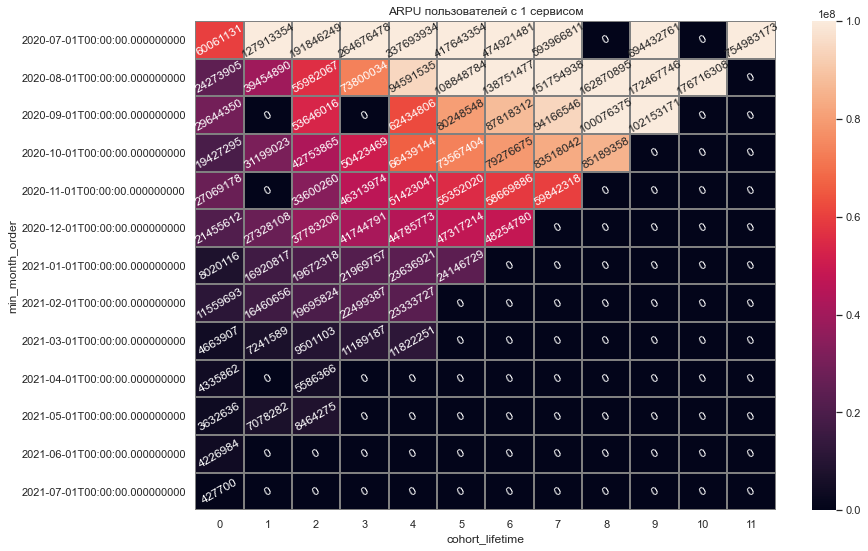

In [28]:
# Изменение ARPU
pivot_ARPU_1 = ARPU_dinamic.pivot_table(index='min_month_order', 
                                        columns='cohort_lifetime', 
                                        values='ARPU', aggfunc='mean').cumsum(axis=1) 
pivot_ARPU_1 = pivot_ARPU_1.fillna(0) 
sns.set(style='white')
ax = plt.figure(figsize=(13, 9))
plt.title('ARPU пользователей с 1 сервисом')
ax = sns.heatmap(pivot_ARPU_1, annot=True, 
            annot_kws={'fontsize':12, 'rotation':30}, 
            fmt='.0f', linewidths=1, linecolor='gray', vmax=100000000) 
#ticklabels = [ARPU_dinamic.min_month_order[int(tick)].strftime('%Y-%m-%d') for tick in ax.get_yticks()]
#ax.set_yticklabels(ticklabels)
None

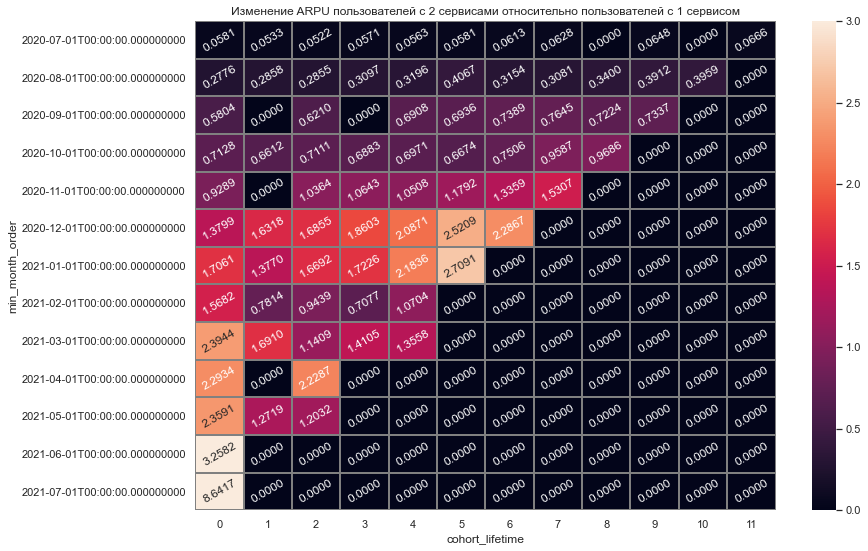

In [29]:
# Изменение ARPU после использования 2х сервисов
pivot_ARPU_2 = ARPU_dinamic.pivot_table(index='min_month_order', 
                                        columns='cohort_lifetime', 
                                        values='ARPU_cum_after_2', aggfunc='mean') 
pivot_ARPU_2 = pivot_ARPU_2.fillna(0) 
sns.set(style='white')
ax = plt.figure(figsize=(13, 9))
plt.title('Изменение ARPU пользователей с 2 сервисами относительно пользователей с 1 сервисом')
ax = sns.heatmap(pivot_ARPU_2, annot=True, 
            annot_kws={'fontsize':12, 'rotation':30}, 
            fmt='.4f', linewidths=1, linecolor='gray', vmax=3) 

None

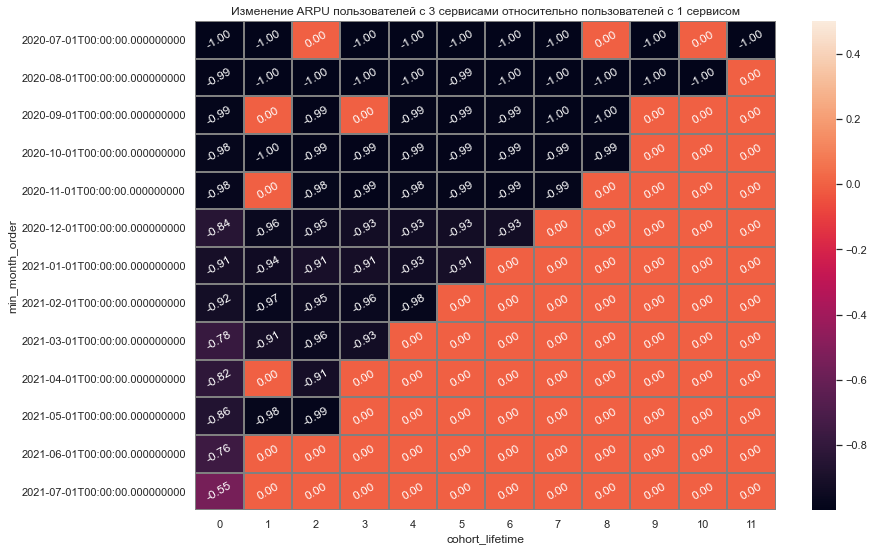

In [30]:
# Изменение ARPU после использования 3х сервисов
pivot_ARPU_3 = ARPU_dinamic.pivot_table(index='min_month_order', 
                                        columns='cohort_lifetime', 
                                        values='ARPU_cum_after_3', aggfunc='mean') 
pivot_ARPU_3 = pivot_ARPU_3.fillna(0) 
sns.set(style='white')
ax = plt.figure(figsize=(13, 9))
plt.title('Изменение ARPU пользователей с 3 сервисами относительно пользователей с 1 сервисом')
ax = sns.heatmap(pivot_ARPU_3, annot=True, 
            annot_kws={'fontsize':12, 'rotation':30}, 
            fmt='.2f', linewidths=1, linecolor='gray', vmax=0.5) 

None

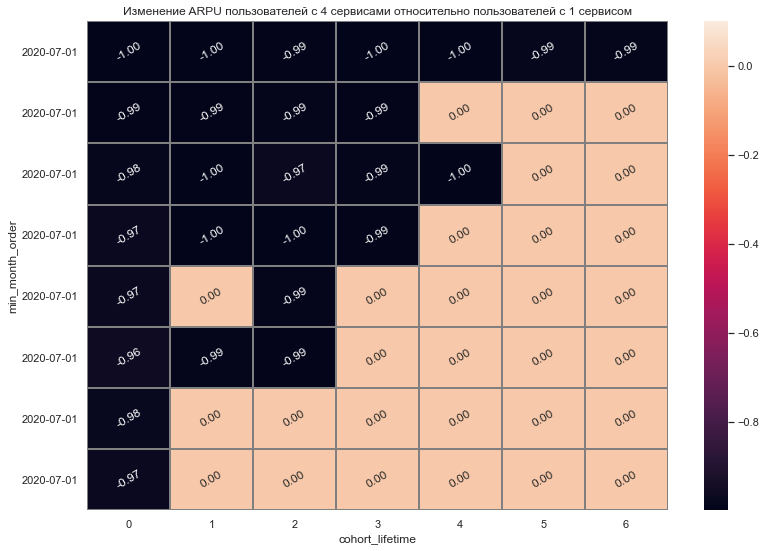

In [31]:
# Изменение ARPU после использования 4х сервисов
pivot_ARPU_4 = ARPU_dinamic.pivot_table(index='min_month_order', 
                                        columns='cohort_lifetime', 
                                        values='ARPU_cum_after_4', aggfunc='mean') 
pivot_ARPU_4 = pivot_ARPU_4.fillna(0) 
sns.set(style='white')
ax = plt.figure(figsize=(13, 9))
plt.title('Изменение ARPU пользователей с 4 сервисами относительно пользователей с 1 сервисом')
ax = sns.heatmap(pivot_ARPU_4, annot=True, 
            annot_kws={'fontsize':12, 'rotation':30}, 
            fmt='.2f', linewidths=1, linecolor='gray', vmax=0.1) 
ticklabels = [ARPU_dinamic.min_month_order[int(tick)].strftime('%Y-%m-%d') for tick in ax.get_yticks()]
ax.set_yticklabels(ticklabels)

None

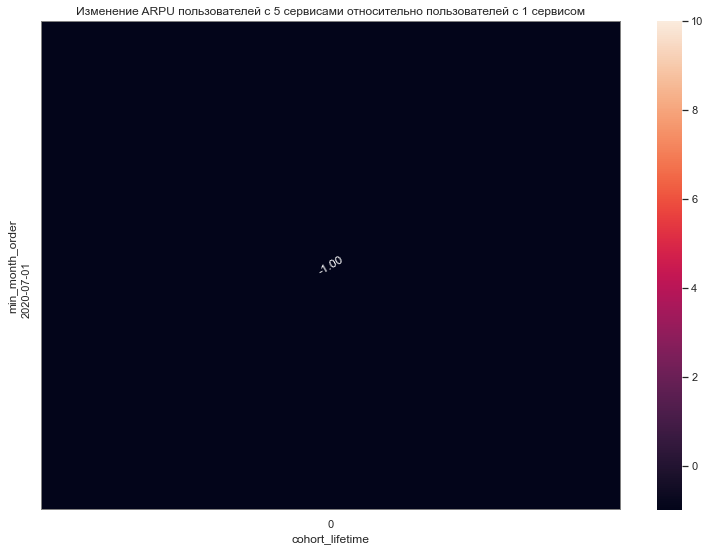

In [32]:
# Изменение ARPU после использования 5 сервисов
pivot_ARPU_5 = ARPU_dinamic.pivot_table(index='min_month_order', 
                                        columns='cohort_lifetime', 
                                        values='ARPU_cum_after_5', aggfunc='mean') 

sns.set(style='white')
ax = plt.figure(figsize=(13, 9))
plt.title('Изменение ARPU пользователей с 5 сервисами относительно пользователей с 1 сервисом')
ax = sns.heatmap(pivot_ARPU_5, annot=True, 
            annot_kws={'fontsize':12, 'rotation':30}, 
            fmt='.2f', linewidths=1, linecolor='gray', vmax=10) 
ticklabels = [ARPU_dinamic.min_month_order[int(tick)].strftime('%Y-%m-%d') for tick in ax.get_yticks()]
ax.set_yticklabels(ticklabels)

None

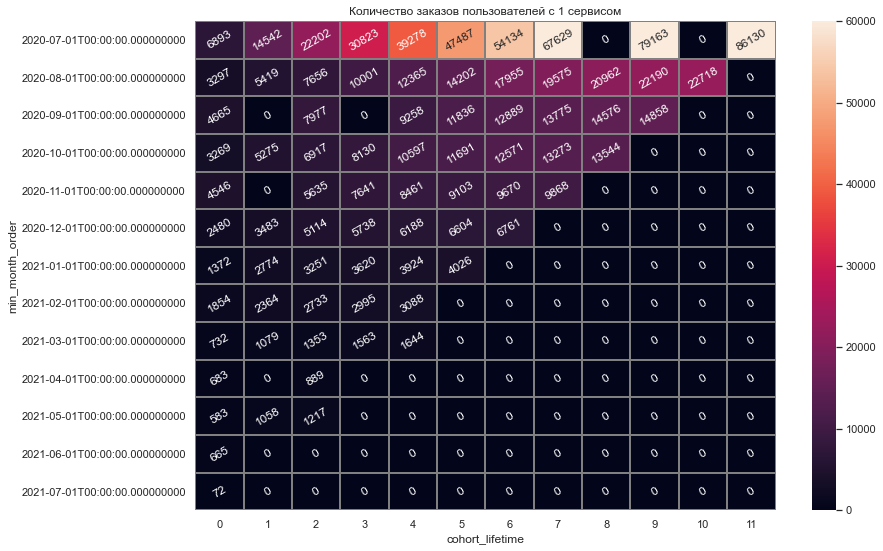

In [33]:
# Изменение количества заказов
pivot_orders_1 = ARPU_dinamic.pivot_table(index='min_month_order', 
                                        columns='cohort_lifetime', 
                                        values='number_orders', aggfunc='mean').cumsum(axis=1) 
pivot_orders_1 = pivot_orders_1.fillna(0) 
sns.set(style='white')
ax = plt.figure(figsize=(13, 9))
plt.title('Количество заказов пользователей с 1 сервисом')
ax = sns.heatmap(pivot_orders_1, annot=True, 
            annot_kws={'fontsize':12, 'rotation':30}, 
            fmt='.0f', linewidths=1, linecolor='gray', vmax=60000) 
#ticklabels = [ARPU_dinamic.min_month_order[int(tick)].strftime('%Y-%m-%d') for tick in ax.get_yticks()]
#ax.set_yticklabels(ticklabels)
None

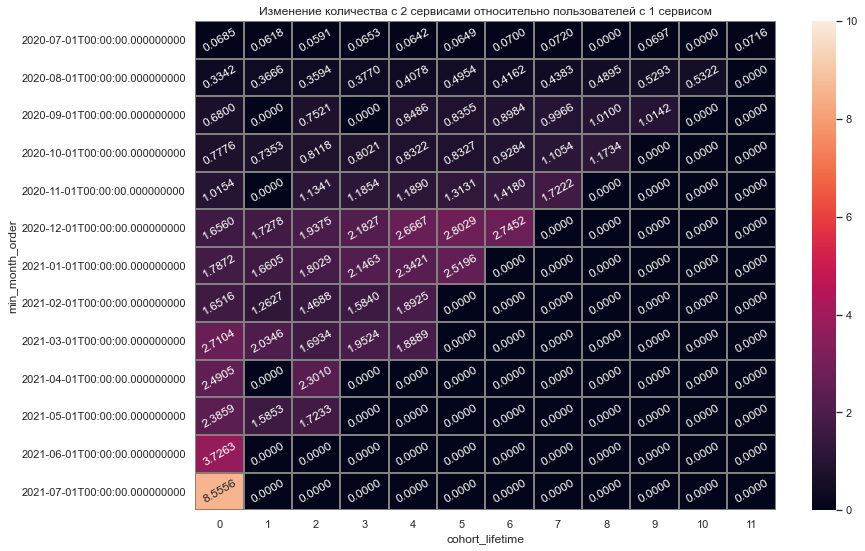

In [34]:
# Изменение количества заказов после использования 2х сервисов
pivot_orders_2 = ARPU_dinamic.pivot_table(index='min_month_order', 
                                        columns='cohort_lifetime', 
                                        values='number_cum_orders_2', aggfunc='mean') 
pivot_orders_2 = pivot_orders_2.fillna(0) 
sns.set(style='white')
ax = plt.figure(figsize=(13, 9))
plt.title('Изменение количества с 2 сервисами относительно пользователей с 1 сервисом')
ax = sns.heatmap(pivot_orders_2, annot=True, 
            annot_kws={'fontsize':12, 'rotation':30}, 
            fmt='.4f', linewidths=1, linecolor='gray', vmax=10) 

None

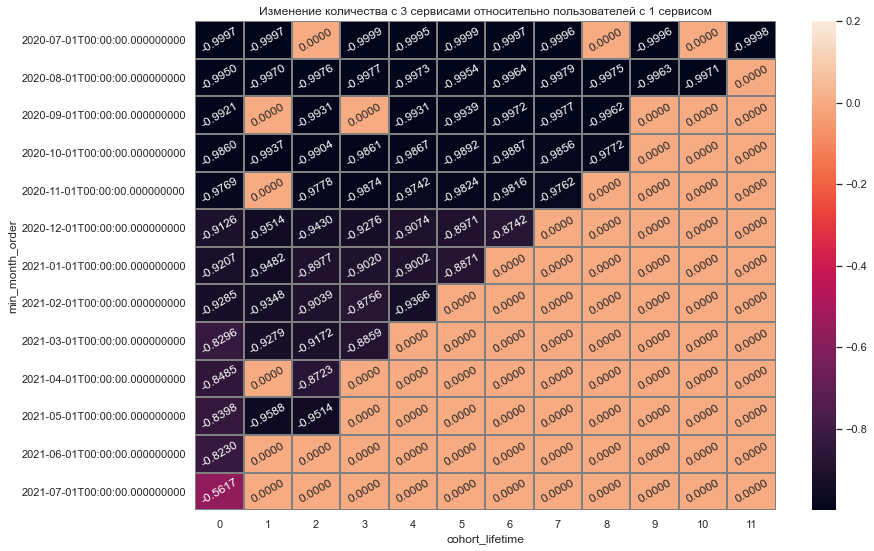

In [35]:
# Изменение количества заказов после использования 3х сервисов
pivot_orders_3 = ARPU_dinamic.pivot_table(index='min_month_order', 
                                        columns='cohort_lifetime', 
                                        values='number_cum_orders_3', aggfunc='mean') 
pivot_orders_3 = pivot_orders_3.fillna(0) 
sns.set(style='white')
ax = plt.figure(figsize=(13, 9))
plt.title('Изменение количества с 3 сервисами относительно пользователей с 1 сервисом')
ax = sns.heatmap(pivot_orders_3, annot=True, 
            annot_kws={'fontsize':12, 'rotation':30}, 
            fmt='.4f', linewidths=1, linecolor='gray', vmax=0.2) 

None

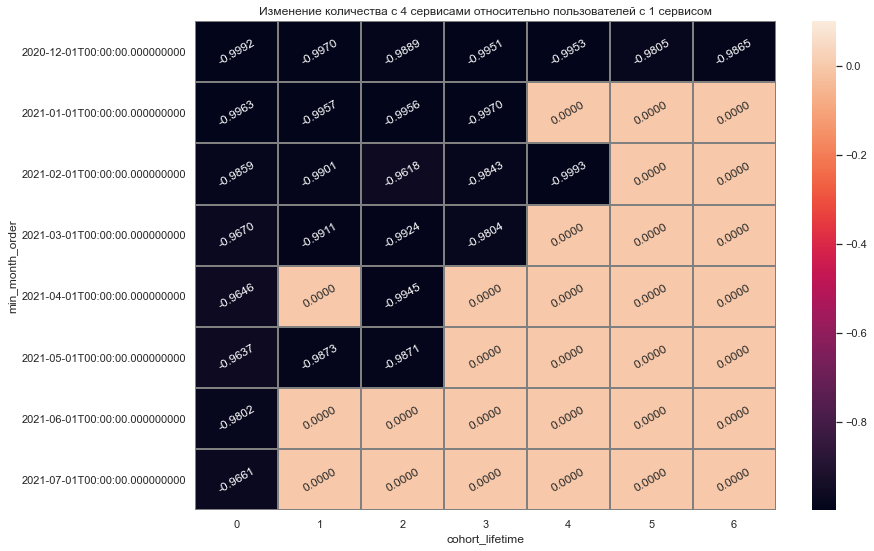

In [36]:
# Изменение количества заказов после использования 4х сервисов
pivot_orders_4 = ARPU_dinamic.pivot_table(index='min_month_order', 
                                        columns='cohort_lifetime', 
                                        values='number_cum_orders_4', aggfunc='mean') 
pivot_orders_4 = pivot_orders_4.fillna(0) 
sns.set(style='white')
ax = plt.figure(figsize=(13, 9))
plt.title('Изменение количества с 4 сервисами относительно пользователей с 1 сервисом')
ax = sns.heatmap(pivot_orders_4, annot=True, 
            annot_kws={'fontsize':12, 'rotation':30}, 
            fmt='.4f', linewidths=1, linecolor='gray', vmax=0.1) 

None

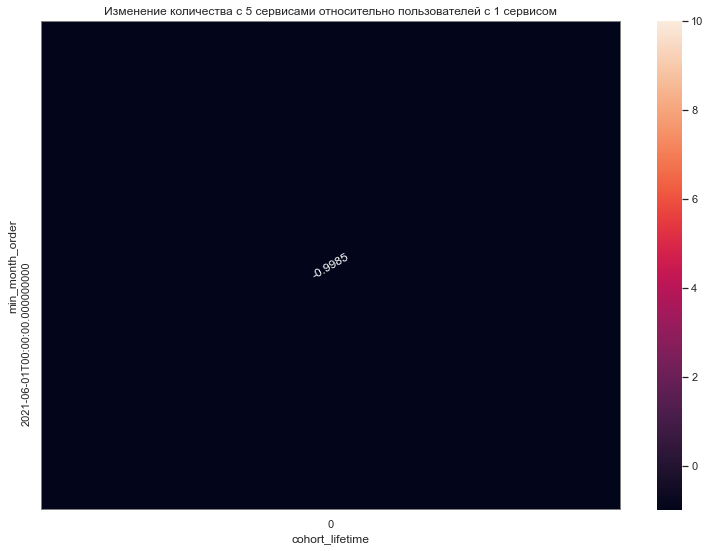

In [37]:
# Изменение количества заказов после использования 5 сервисов
pivot_orders_5 = ARPU_dinamic.pivot_table(index='min_month_order', 
                                        columns='cohort_lifetime', 
                                        values='number_cum_orders_5', aggfunc='mean') 
pivot_orders_5 = pivot_orders_5.fillna(0) 
sns.set(style='white')
ax = plt.figure(figsize=(13, 9))
plt.title('Изменение количества с 5 сервисами относительно пользователей с 1 сервисом')
ax = sns.heatmap(pivot_orders_5, annot=True, 
            annot_kws={'fontsize':12, 'rotation':30}, 
            fmt='.4f', linewidths=1, linecolor='gray', vmax=10) 

None

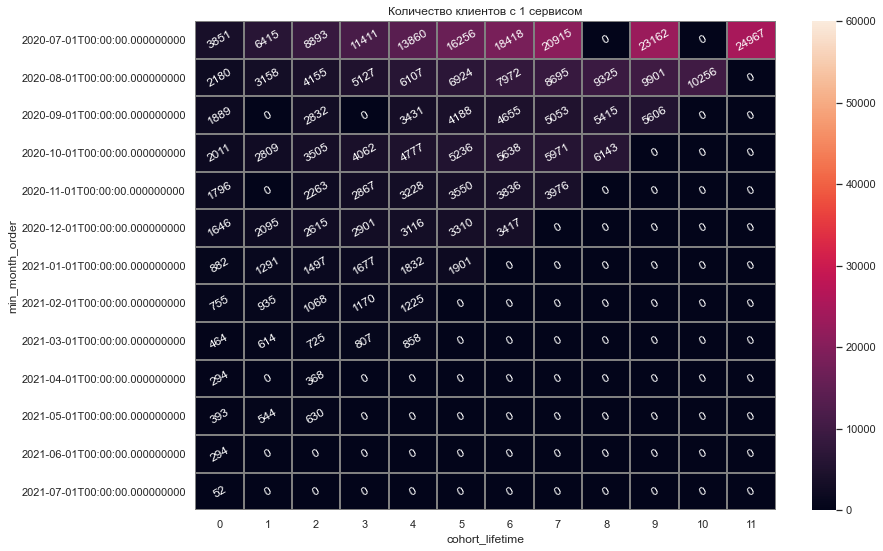

In [38]:
# Изменение количества клиентов
pivot_user_id_1 = ARPU_dinamic.pivot_table(index='min_month_order', 
                                        columns='cohort_lifetime', 
                                        values='number_user_id', aggfunc='mean').cumsum(axis=1) 
pivot_user_id_1 = pivot_user_id_1.fillna(0) 
sns.set(style='white')
ax = plt.figure(figsize=(13, 9))
plt.title('Количество клиентов с 1 сервисом')
ax = sns.heatmap(pivot_user_id_1, annot=True, 
            annot_kws={'fontsize':12, 'rotation':30}, 
            fmt='.0f', linewidths=1, linecolor='gray', vmax=60000) 
#ticklabels = [ARPU_dinamic.min_month_order[int(tick)].strftime('%Y-%m-%d') for tick in ax.get_yticks()]
#ax.set_yticklabels(ticklabels)
None

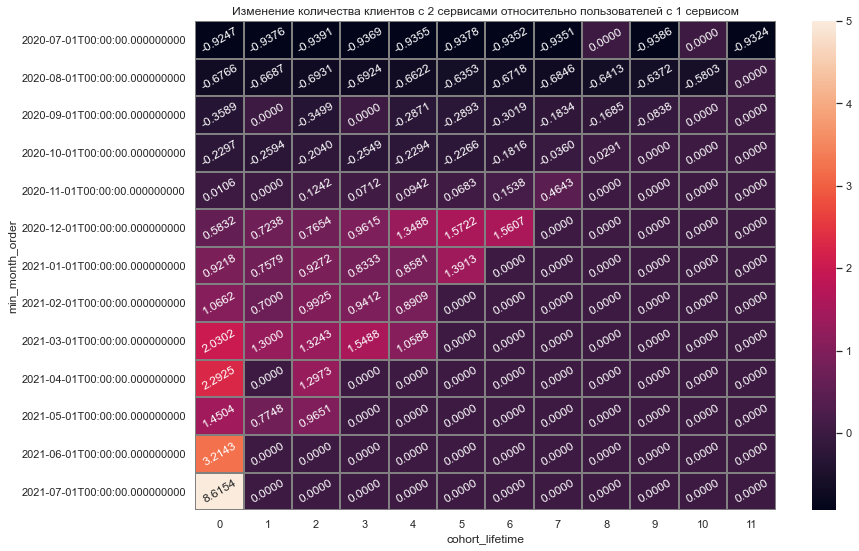

In [39]:
# Изменение количества клиентов после использования 2 сервисов
pivot_user_id_2 = ARPU_dinamic.pivot_table(index='min_month_order', 
                                        columns='cohort_lifetime', 
                                        values='number_user_id_din_2', aggfunc='mean') 
pivot_user_id_2 = pivot_user_id_2.fillna(0) 
sns.set(style='white')
ax = plt.figure(figsize=(13, 9))
plt.title('Изменение количества клиентов с 2 сервисами относительно пользователей с 1 сервисом')
ax = sns.heatmap(pivot_user_id_2, annot=True, 
            annot_kws={'fontsize':12, 'rotation':30}, 
            fmt='.4f', linewidths=1, linecolor='gray', vmax=5) 

None

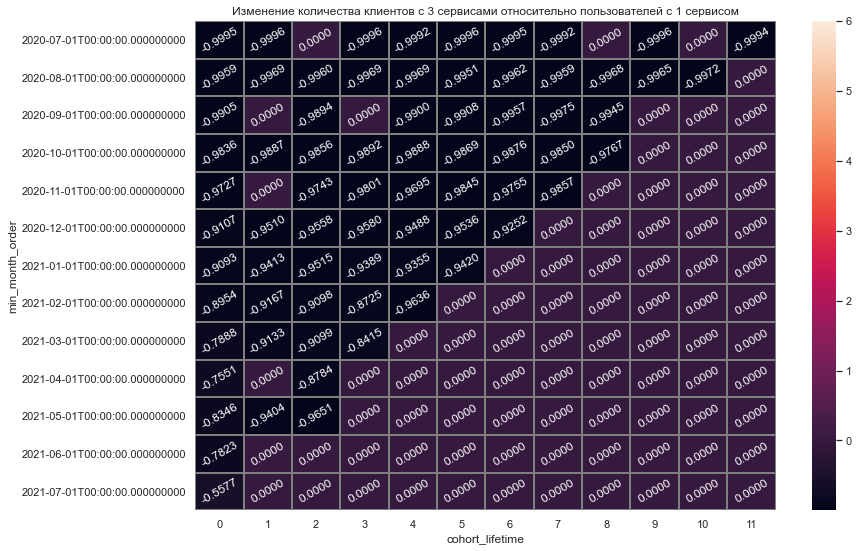

In [40]:
# Изменение количества клиентов после использования 3 сервисов
pivot_user_id_3 = ARPU_dinamic.pivot_table(index='min_month_order', 
                                        columns='cohort_lifetime', 
                                        values='number_user_id_din_3', aggfunc='mean') 
pivot_user_id_3 = pivot_user_id_3.fillna(0) 
sns.set(style='white')
ax = plt.figure(figsize=(13, 9))
plt.title('Изменение количества клиентов с 3 сервисами относительно пользователей с 1 сервисом')
ax = sns.heatmap(pivot_user_id_3, annot=True, 
            annot_kws={'fontsize':12, 'rotation':30}, 
            fmt='.4f', linewidths=1, linecolor='gray', vmax=6) 

None

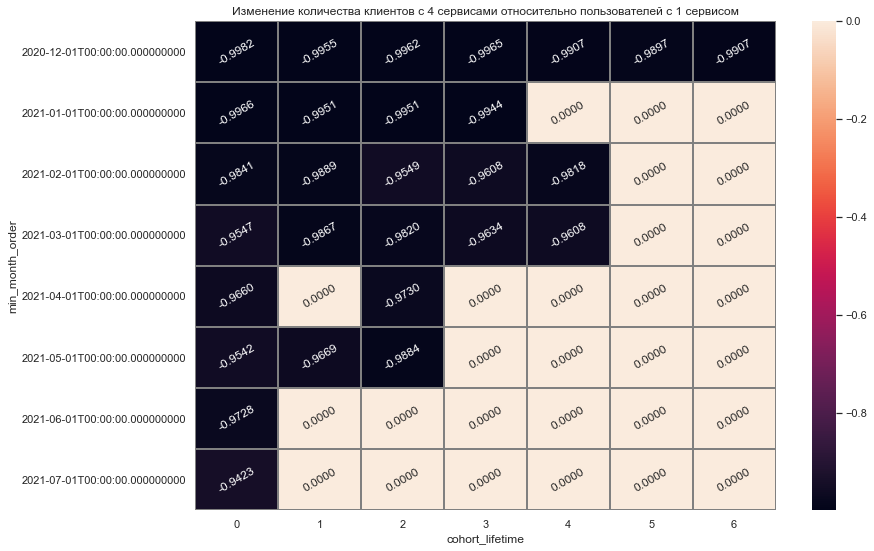

In [41]:
# Изменение количества клиентов после использования 4 сервисов
pivot_user_id_4 = ARPU_dinamic.pivot_table(index='min_month_order', 
                                        columns='cohort_lifetime', 
                                        values='number_user_id_din_4', aggfunc='mean') 
pivot_user_id_4 = pivot_user_id_4.fillna(0) 
sns.set(style='white')
ax = plt.figure(figsize=(13, 9))
plt.title('Изменение количества клиентов с 4 сервисами относительно пользователей с 1 сервисом')
ax = sns.heatmap(pivot_user_id_4, annot=True, 
            annot_kws={'fontsize':12, 'rotation':30}, 
            fmt='.4f', linewidths=1, linecolor='gray', vmax=0) 

None

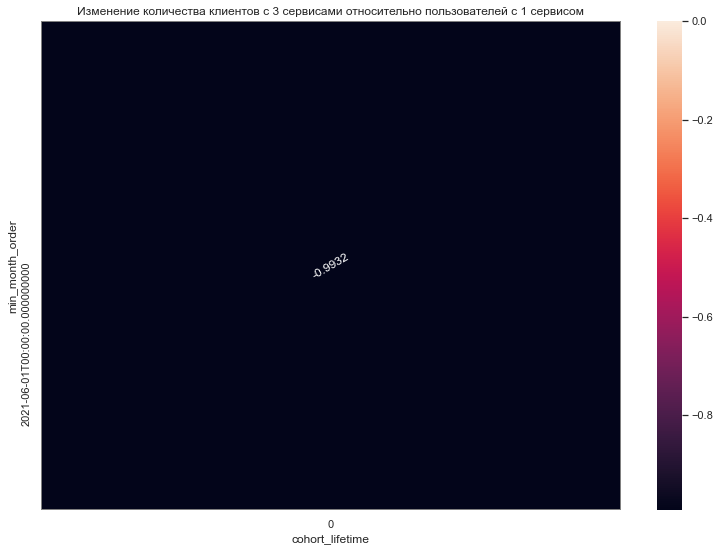

In [42]:
# Изменение количества клиентов после использования 4 сервисов
pivot_user_id_5 = ARPU_dinamic.pivot_table(index='min_month_order', 
                                        columns='cohort_lifetime', 
                                        values='number_user_id_din_5', aggfunc='mean') 
pivot_user_id_5 = pivot_user_id_5.fillna(0) 
sns.set(style='white')
ax = plt.figure(figsize=(13, 9))
plt.title('Изменение количества клиентов с 3 сервисами относительно пользователей с 1 сервисом')
ax = sns.heatmap(pivot_user_id_5, annot=True, 
            annot_kws={'fontsize':12, 'rotation':30}, 
            fmt='.4f', linewidths=1, linecolor='gray', vmax=0) 

None

### Вывод

In [43]:
При рассмотрении тепловых карт можно отметить следующее:
- при переходе от 1 сервиса к 2 ARPU имеет уверенную тенденцию роста
- при дальнейшем увеличении количества сервисов(от 3 к 5) тенденция роста изменяется на снижение ARPU начиная с 0 меясца
- ситуация с количеством заказов при переходе от 1 сервиса к 2 аналогична ARPU
- при дальнейшем увеличении количества сервисов(от 3 к 5) тенденция роста сменяется на снижение начиная с 0 меясца
- количество пользователей при изменениии сервисов стабильно уменьшается

SyntaxError: invalid syntax (<ipython-input-43-ad3272829413>, line 1)